In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
import matplotlib

matplotlib.rcParams.update({"font.size": 20})
import os, sys

os.chdir("/project/GCRB/Hon_lab/s440862/courses/se/MODULE_3_MATERIALS/mod3")

output_path = "output/"

In [158]:
### 'task', 'dataset_name', 'model_name', 'temperature', 'score', 'tool'
raw_metrics = []

TOOL = False
for DATASET_NAME in ["genehop", "geneturing"]:
    for MODEL_NAME in ["gpt-4.1", "qwen3:4b"]:
        for TEMPERATURE in [0.1, 0.5, 1]:
            data = pd.read_csv(
                os.path.join(
                    output_path, f"{DATASET_NAME}_{MODEL_NAME}_{TEMPERATURE}.csv"
                )
            )
            data = data[data.success == True]
            for t in data.task.unique():
                s = data[data.task == t]["score"].mean()
                raw_metrics.append([t, DATASET_NAME, MODEL_NAME, TEMPERATURE, s, TOOL])

TOOL = True
MODEL_NAME = 'gpt-4.1'
TEMPERATURE = 0.5
for DATASET_NAME in ['genehop', 'geneturing']:
    data = pd.read_csv(os.path.join(output_path, f'{DATASET_NAME}_{MODEL_NAME}_tool_use_temp{TEMPERATURE}.csv'))
    data = data[data.success==True]
    for t in data.task.unique():
        s = data[data.task==t]['score'].mean()
        raw_metrics.append([t, DATASET_NAME, MODEL_NAME, TEMPERATURE, s, TOOL])

raw_metrics = pd.DataFrame(
    raw_metrics,
    columns=["task", "dataset_name", "model_name", "temperature", "score", "tool"],
)
raw_metrics["normalized_score"] = raw_metrics.groupby("task")["score"].transform(lambda x: x / x.max())
raw_metrics["normalized_score"] = (raw_metrics["normalized_score"].replace([np.inf, -np.inf], np.nan).fillna(0))

In [ ]:
# metric_task_map = defaultdict(
#     lambda: exact_match,
#     {
#         "sequence gene alias": Levenshtein_score,
#         "Disease gene location": Levenshtein_score,
#         "SNP gene function": cos_similarity,
#     },
# )

In [ ]:
metrics = raw_metrics[raw_metrics["tool"] == False]

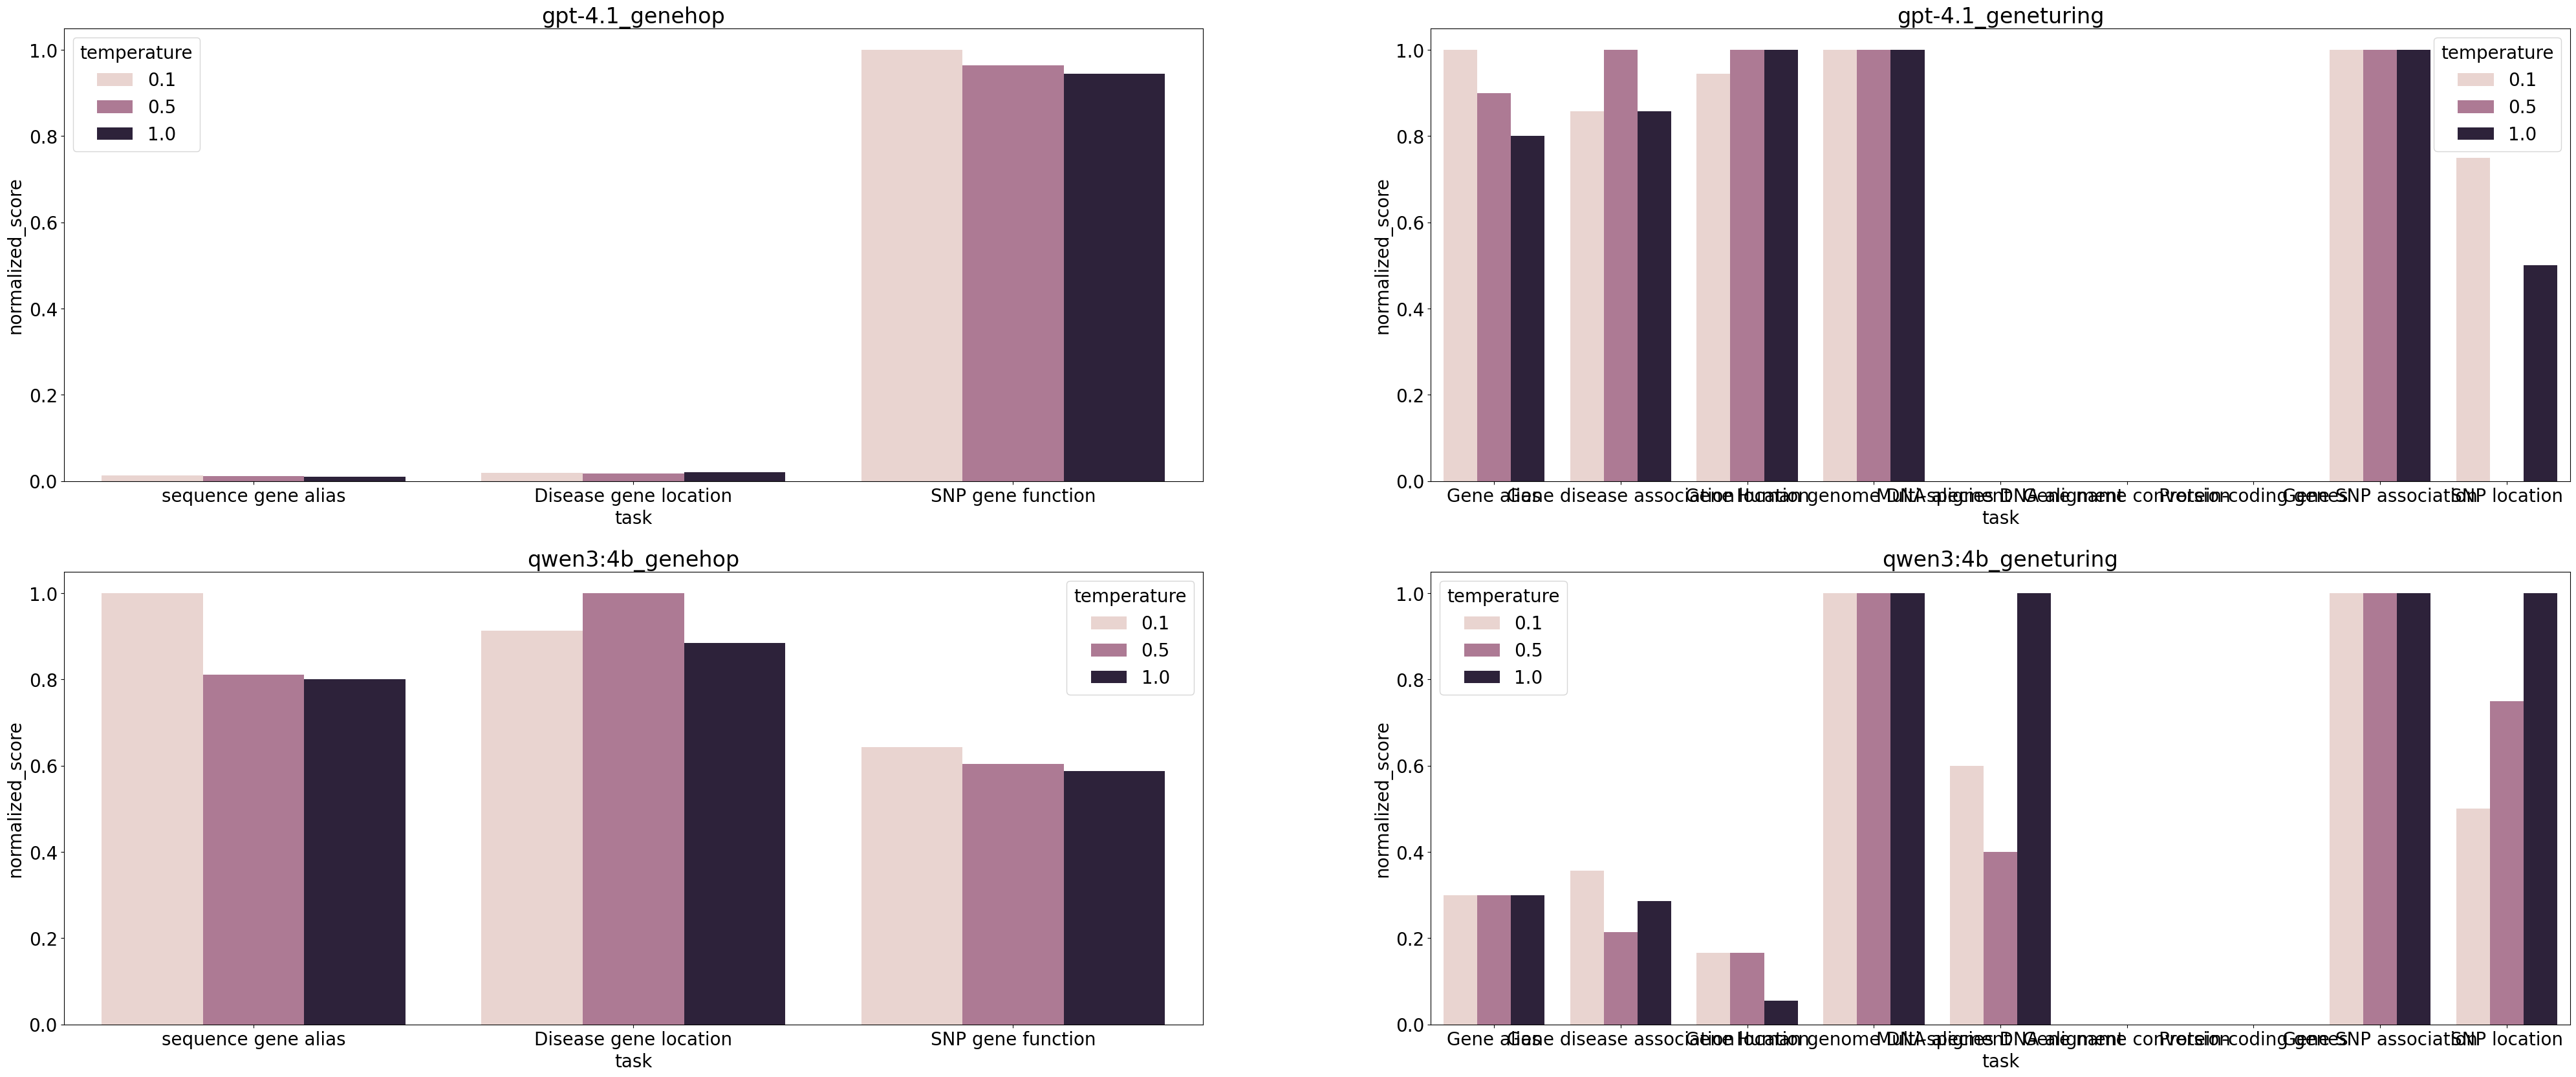

In [ ]:
# comparing temperature

plt.figure(figsize=(50, 20))
nRow = len(metrics.model_name.unique())
nCol = len(metrics.dataset_name.unique())

cnt = 1
for _model_name in metrics.model_name.unique():
    for _dataset_name in metrics.dataset_name.unique():
        plt.subplot(nRow * 100 + nCol * 10 + cnt)
        img = metrics[
            (metrics.model_name == _model_name)
            & (metrics.dataset_name == _dataset_name)
        ]
        sns.barplot(data=img, x="task", y="normalized_score", hue="temperature")
        plt.title(f"{_model_name}_{_dataset_name}")
        cnt += 1

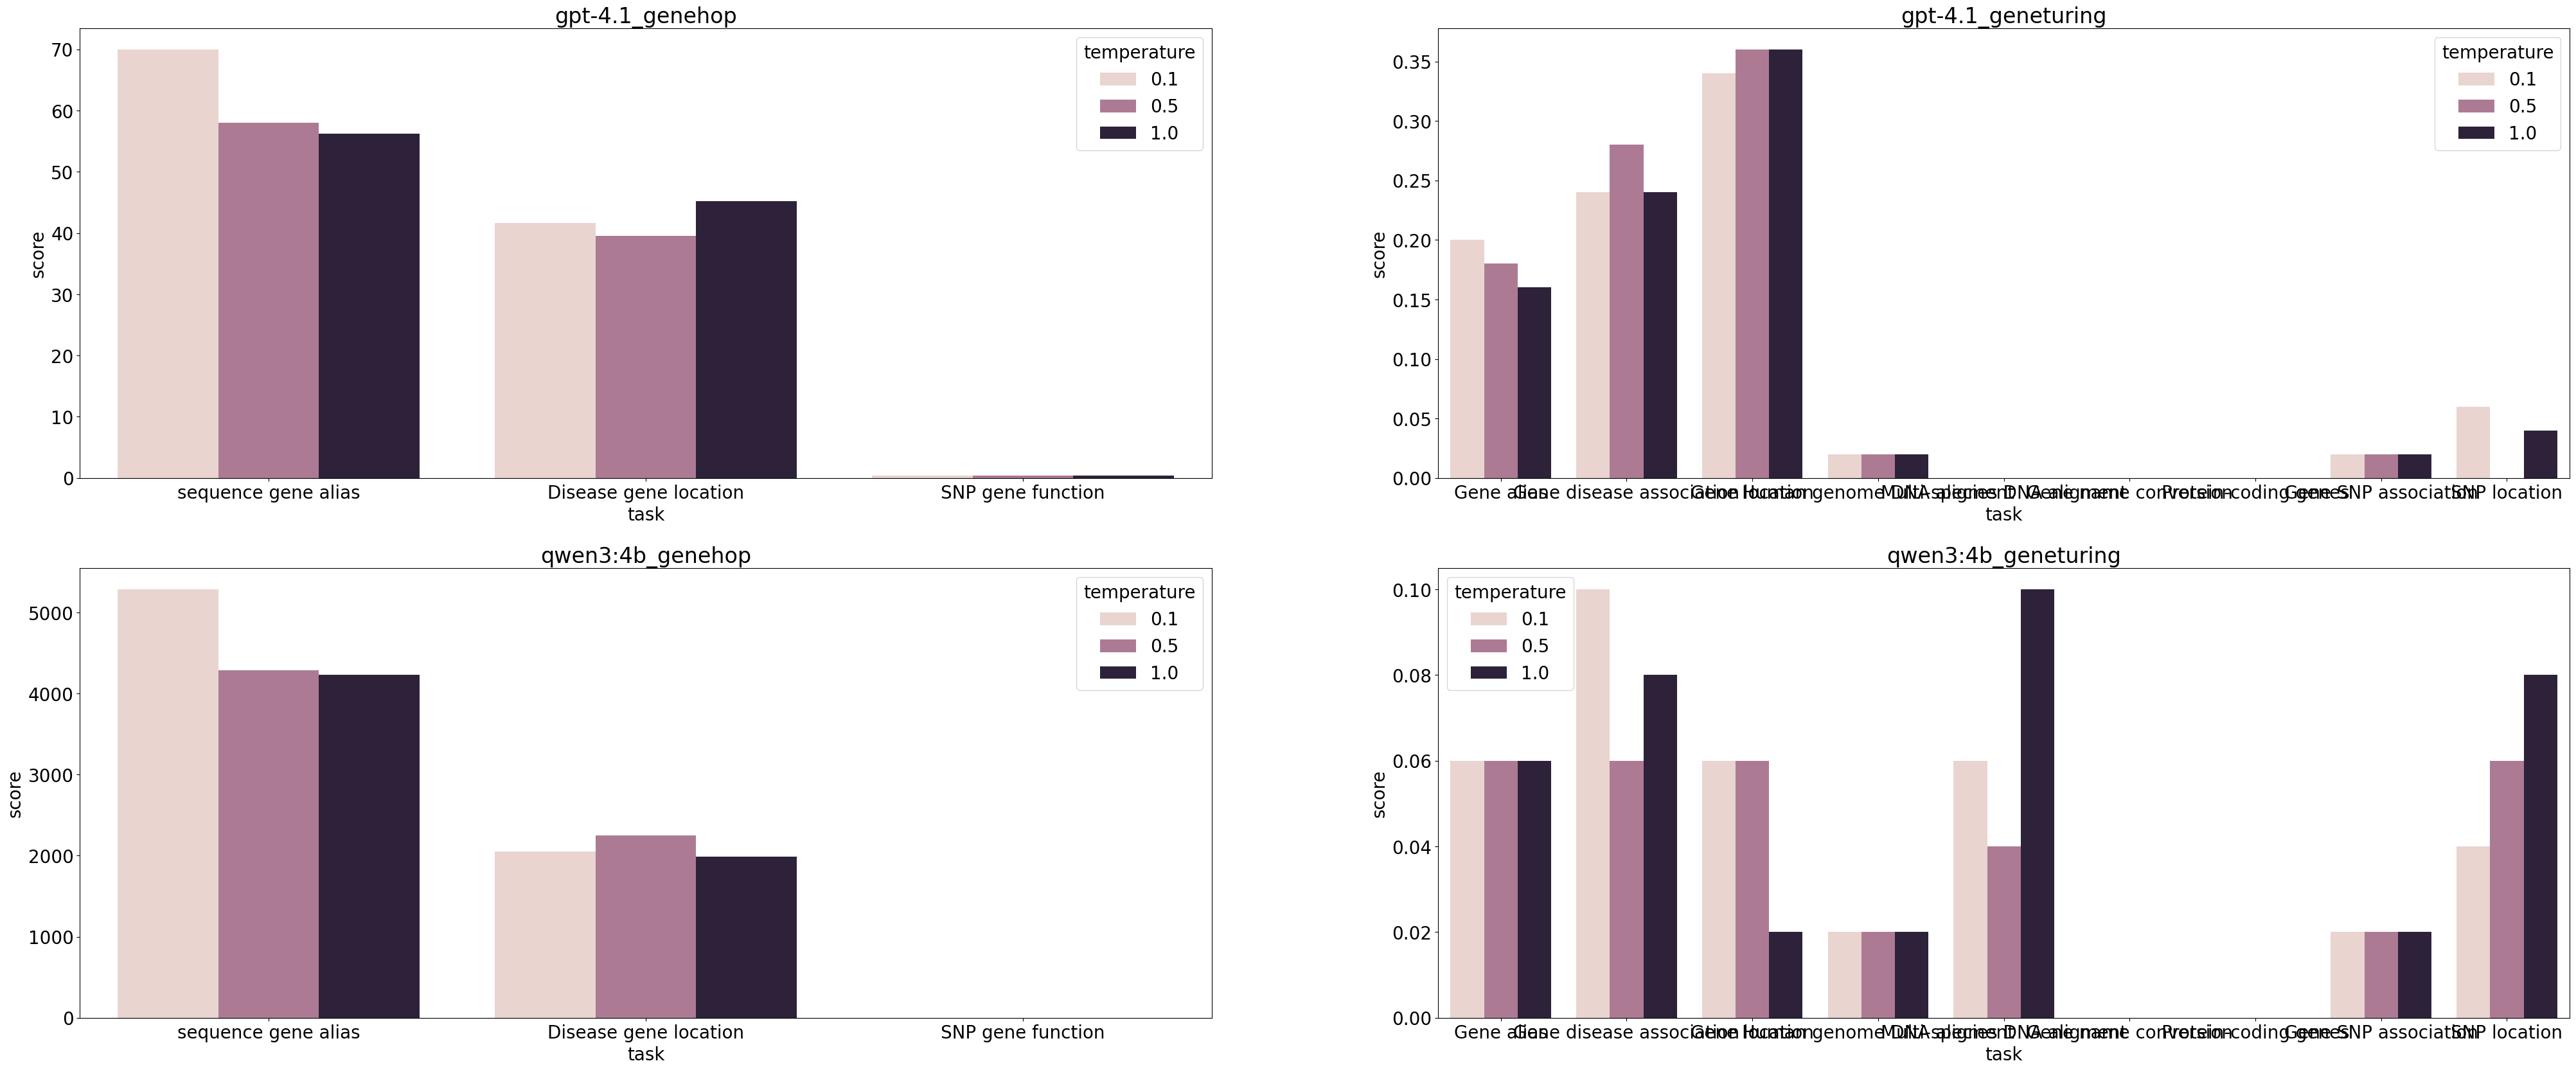

In [ ]:
plt.figure(figsize=(50, 20))

cnt = 1
for _model_name in metrics.model_name.unique():
    for _dataset_name in metrics.dataset_name.unique():
        plt.subplot(nRow * 100 + nCol * 10 + cnt)
        img = metrics[
            (metrics.model_name == _model_name)
            & (metrics.dataset_name == _dataset_name)
        ]
        sns.barplot(data=img, x="task", y="score", hue="temperature")
        plt.title(f"{_model_name}_{_dataset_name}")
        cnt += 1

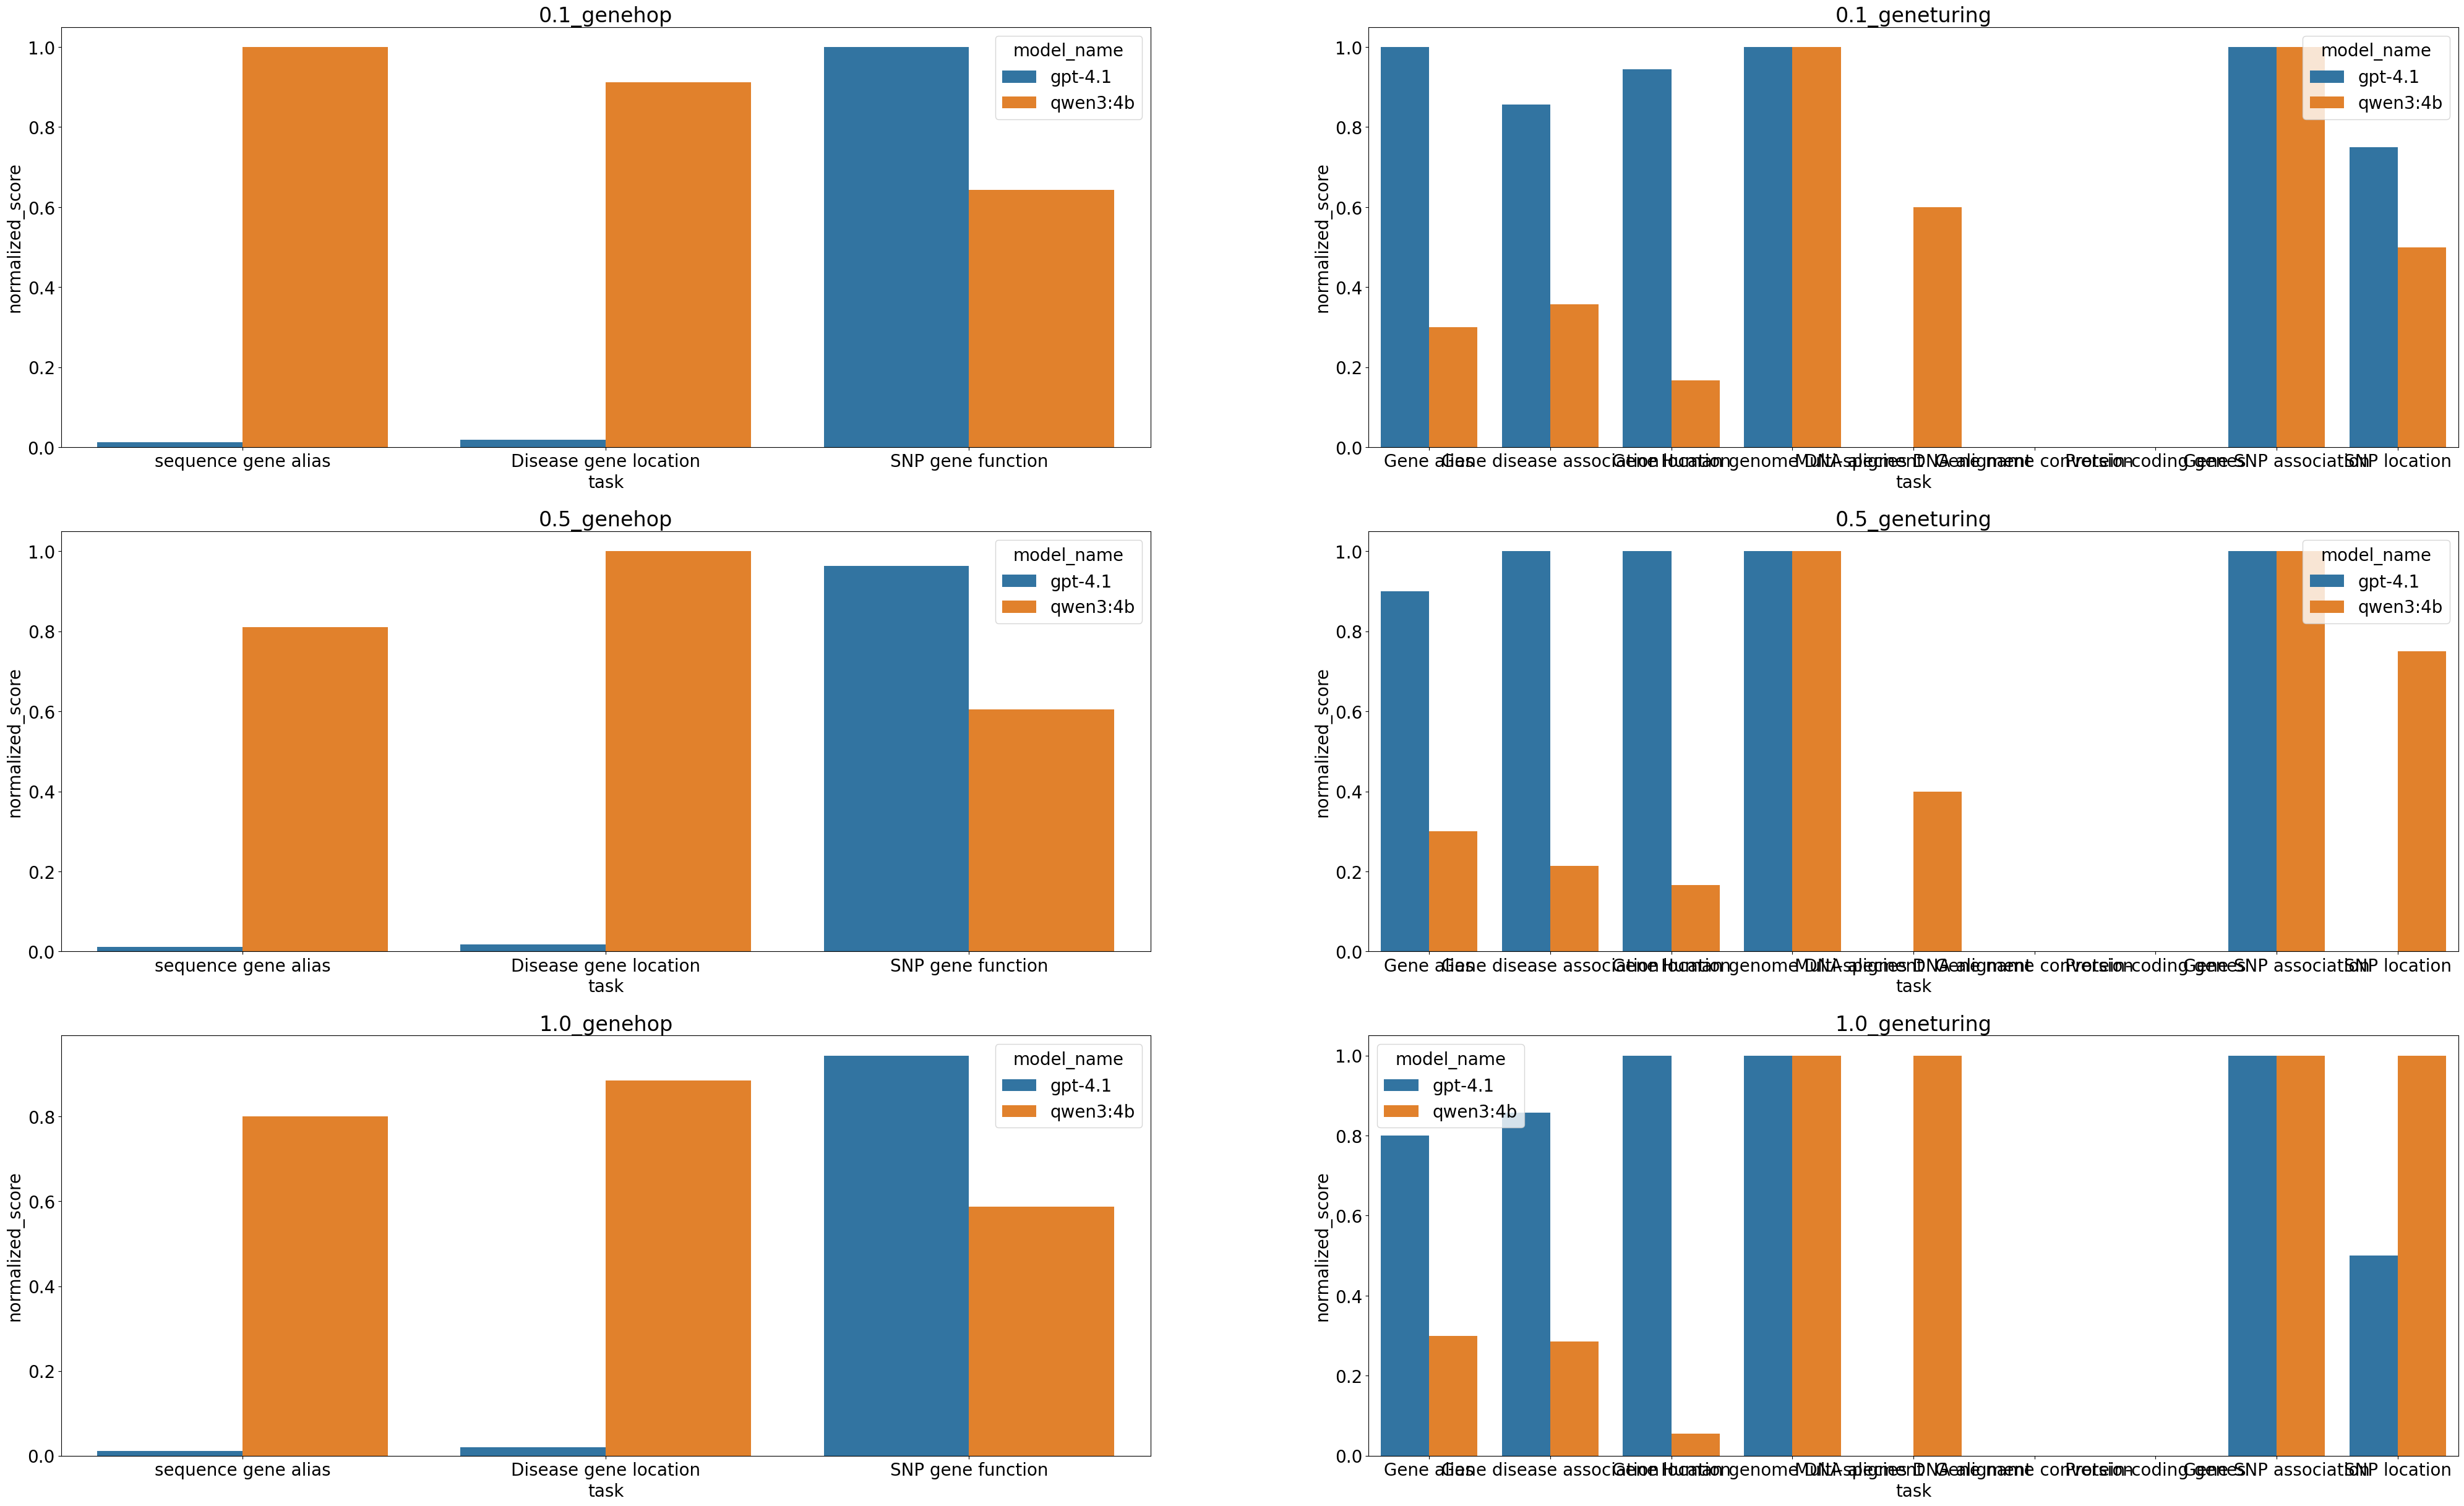

In [ ]:
# comparing gpt-4.1 and qwen3:4b

plt.figure(figsize=(50, 30))
nRow = len(metrics.temperature.unique())
nCol = len(metrics.dataset_name.unique())

cnt = 1
for _temperature in metrics.temperature.unique():
    for _dataset_name in metrics.dataset_name.unique():
        plt.subplot(nRow * 100 + nCol * 10 + cnt)
        img = metrics[
            (metrics.temperature == _temperature)
            & (metrics.dataset_name == _dataset_name)
        ]
        sns.barplot(data=img, x="task", y="normalized_score", hue="model_name")
        plt.title(f"{_temperature}_{_dataset_name}")
        cnt += 1

<Axes: xlabel='task', ylabel='normalized_score'>

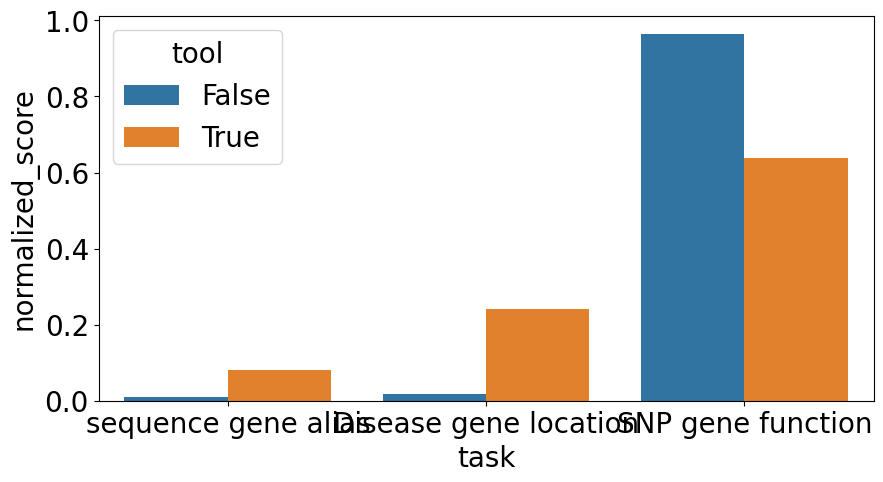

In [170]:
# Does using tools help?
img = raw_metrics[(raw_metrics.model_name=='gpt-4.1')&(raw_metrics.temperature==0.5)&(raw_metrics.dataset_name=='genehop')]
plt.figure(figsize=(10, 5))
sns.barplot(data=img, x='task', y='normalized_score', hue='tool')

### LLM evaluation

In [108]:
from openai import OpenAI, AzureOpenAI
from dotenv import load_dotenv
from tqdm import tqdm

load_dotenv("azure.env")

AZURE_OPENAI_ENDPOINT = os.getenv("AZURE_OPENAI_ENDPOINT")
AZURE_OPENAI_KEY = os.getenv("AZURE_OPENAI_KEY")
AZURE_OPENAI_API_VERSION = os.getenv("AZURE_OPENAI_API_VERSION")

client = AzureOpenAI(
            api_version=AZURE_OPENAI_API_VERSION,
            azure_endpoint=AZURE_OPENAI_ENDPOINT,
            api_key=AZURE_OPENAI_KEY,
        )
# deployment_name = "gpt-4-judge"
deployment_name = 'gpt-4.1'


def evaluate_trace(question, candidate, gold, rubric):
    prompt = f"""You are a domain expert grading an AI response based on genetics question.

                Question:
                {question}

                Candidate Answer:
                {candidate}

                Gold Standard Answer:
                {gold}

                Rubric:
                {rubric}

                Instructions:
                Score the candidate's answer on a scale of 1 to 5 based on the rubric. Provide a justification for the score.
                Return your answer in a list format:
                Score: X,'\n'Explanation: ...
                """
    response = client.chat.completions.create(
        model=deployment_name,
        messages=[
            {
                "role": "system",
                "content": "You are a meticulous evaluator following an academic grading rubric.",
            },
            {"role": "user", "content": prompt},
        ],
        temperature=0.2,
    )
    evaluation_msg = response.choices[0].message.content
    # score, explaination = evaluation_msg.split(',\n')
    # score = score[-1]
    # explaination = explaination[12:]
    return evaluation_msg


# Example usage
question = "What is the capital of France?"
candidate = "The capital of France is Lyon."
gold = "The capital of France is Paris."
rubric = "Correctness of factual information."

evaluate_trace(question, candidate, gold, rubric)

"Score: 1,\nExplanation: The candidate's answer is factually incorrect. The capital of France is Paris, not Lyon. According to the rubric, which prioritizes correctness of factual information, this answer does not meet the requirement and thus receives the lowest score."

In [110]:
TOOL = False
DATASET_NAME = 'genehop'
for MODEL_NAME in ["gpt-4.1", "qwen3:4b"]:
    for TEMPERATURE in [0.1, 0.5, 1]:
        EXPERIMENT_NAME = f"{DATASET_NAME}_{MODEL_NAME}_{TEMPERATURE}"
        FILE_PATH = os.path.join(output_path, f"{EXPERIMENT_NAME}.csv")
        data = pd.read_csv(FILE_PATH)
        eval_list = []
        for index, row in tqdm(data.iterrows(), total=len(data), desc=f"Evaluating {EXPERIMENT_NAME}"):
            question = row["question"]
            gold = str(row["answer"]) 
            candidate = row["raw_prediction"]
            rubric = "Correctness of factual information."

            eval_msg = evaluate_trace(question, candidate, gold, rubric)
            eval_list.append(eval_msg)
        data['LLM_evaluation'] = eval_list
        # data['LLM_grade'] = [item.split('\n')[0][-2]]
        data.to_csv(FILE_PATH, index=None)


        

Evaluating genehop_qwen3:4b_1: 100%|██████████| 150/150 [04:10<00:00,  1.67s/it]


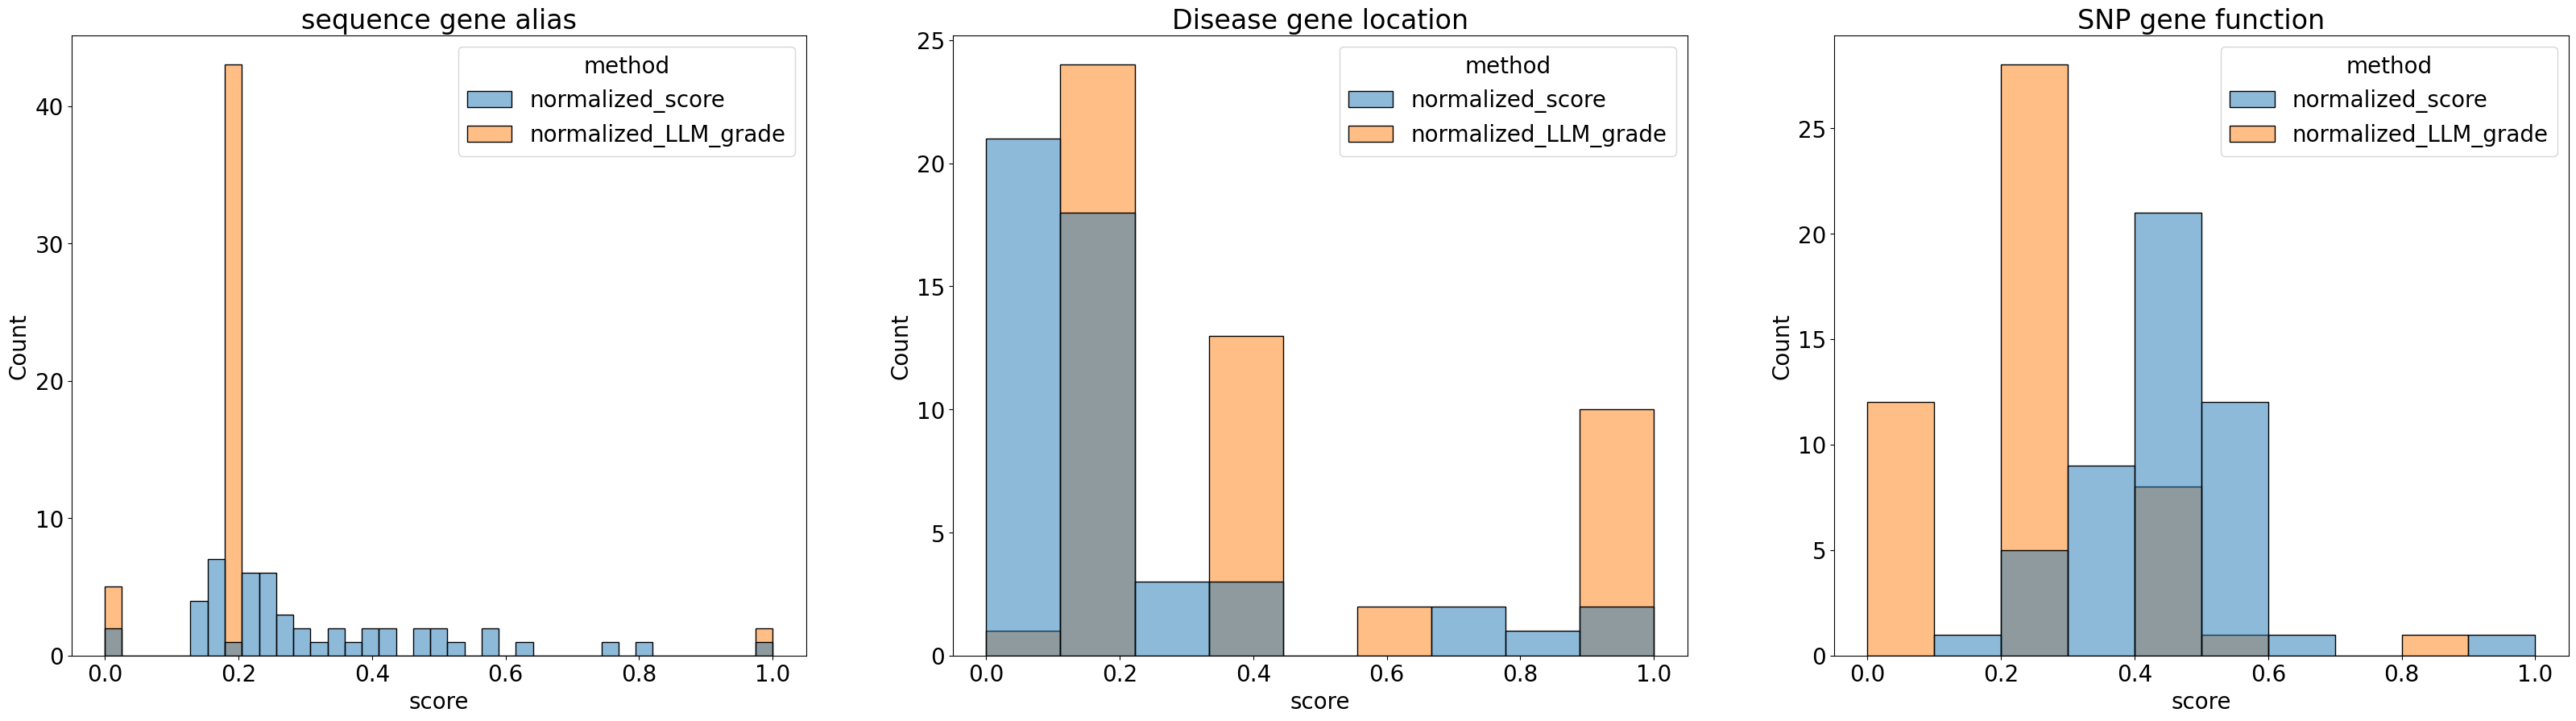

In [ ]:
DATASET_NAME = 'genehop'
MODEL_NAME = 'gpt-4.1'
TEMPERATURE = 1

EXPERIMENT_NAME = f"{DATASET_NAME}_{MODEL_NAME}_{TEMPERATURE}"
FILE_PATH = os.path.join(output_path, f"{EXPERIMENT_NAME}.csv")
data = pd.read_csv(FILE_PATH)
data['LLM_grade'] = [item.split(',\n')[0][-1] if ',\n' in item else np.nan for item in data['LLM_evaluation']]
data['normalized_LLM_grade'] = data['LLM_grade'].fillna(0).astype(int)/5
data["normalized_score"] = data.groupby("task")["score"].transform(lambda x: x / x.max())
data["normalized_score"] = (data["normalized_score"].replace([np.inf, -np.inf], np.nan).fillna(0))

plt.figure(figsize=(40, 10))
cnt = 1
for _task in data.task.unique():
    plt.subplot(130+cnt)
    img = data[data.task==_task][['normalized_score', 'normalized_LLM_grade']].stack().reset_index()
    img.columns = ['id', 'method', 'score']
    sns.histplot(data=img, x='score', hue='method')
    plt.title(_task)
    cnt += 1

In [144]:
### 'task', 'dataset_name', 'model_name', 'temperature', 'score', 'tool'
raw_metrics = []

TOOL = False
for DATASET_NAME in ["genehop"]:
    for MODEL_NAME in ["gpt-4.1", "qwen3:4b"]:
        for TEMPERATURE in [0.1, 0.5, 1]:
            data = pd.read_csv(
                os.path.join(
                    output_path, f"{DATASET_NAME}_{MODEL_NAME}_{TEMPERATURE}.csv"
                )
            )
            data = data[data.success == True]
            data['LLM_grade'] = [item.split(',\n')[0][-1] if ',\n' in item else 0 for item in data['LLM_evaluation']]
            data['LLM_grade'] = data['LLM_grade'].astype(int)
            for t in data.task.unique():
                s = data[data.task == t]["score"].mean()
                g = data[data.task == t]["LLM_grade"].mean()
                raw_metrics.append([t, DATASET_NAME, MODEL_NAME, TEMPERATURE, s, g, TOOL])

raw_metrics = pd.DataFrame(
    raw_metrics,
    columns=["task", "dataset_name", "model_name", "temperature", "score", "LLM_grade", "tool"],
)
raw_metrics["normalized_score"] = raw_metrics.groupby("task")["score"].transform(lambda x: x / x.max())
raw_metrics["normalized_score"] = (raw_metrics["normalized_score"].replace([np.inf, -np.inf], np.nan).fillna(0))

raw_metrics["normalized_LLM_grade"] = raw_metrics["LLM_grade"]/5

In [150]:
raw_metrics

,task,dataset_name,model_name,temperature,score,LLM_grade,tool,normalized_score,normalized_LLM_grade
0,sequence gene alias,genehop,gpt-4.1,0.1,69.980000,1.08,False,0.013242,0.216
1,Disease gene location,genehop,gpt-4.1,0.1,41.680000,2.18,False,0.018534,0.436
2,SNP gene function,genehop,gpt-4.1,0.1,0.367097,0.92,False,1.000000,0.184
3,sequence gene alias,genehop,gpt-4.1,0.5,57.980000,1.04,False,0.010971,0.208
4,Disease gene location,genehop,gpt-4.1,0.5,39.520000,2.10,False,0.017573,0.420
5,SNP gene function,genehop,gpt-4.1,0.5,0.353878,1.08,False,0.963991,0.216
6,sequence gene alias,genehop,gpt-4.1,1.0,56.280000,1.06,False,0.010649,0.212
7,Disease gene location,genehop,gpt-4.1,1.0,45.220000,2.12,False,0.020108,0.424
8,SNP gene function,genehop,gpt-4.1,1.0,0.346556,1.02,False,0.944046,0.204
9,sequence gene alias,genehop,qwen3:4b,0.1,5284.760000,1.02,False,1.000000,0.204


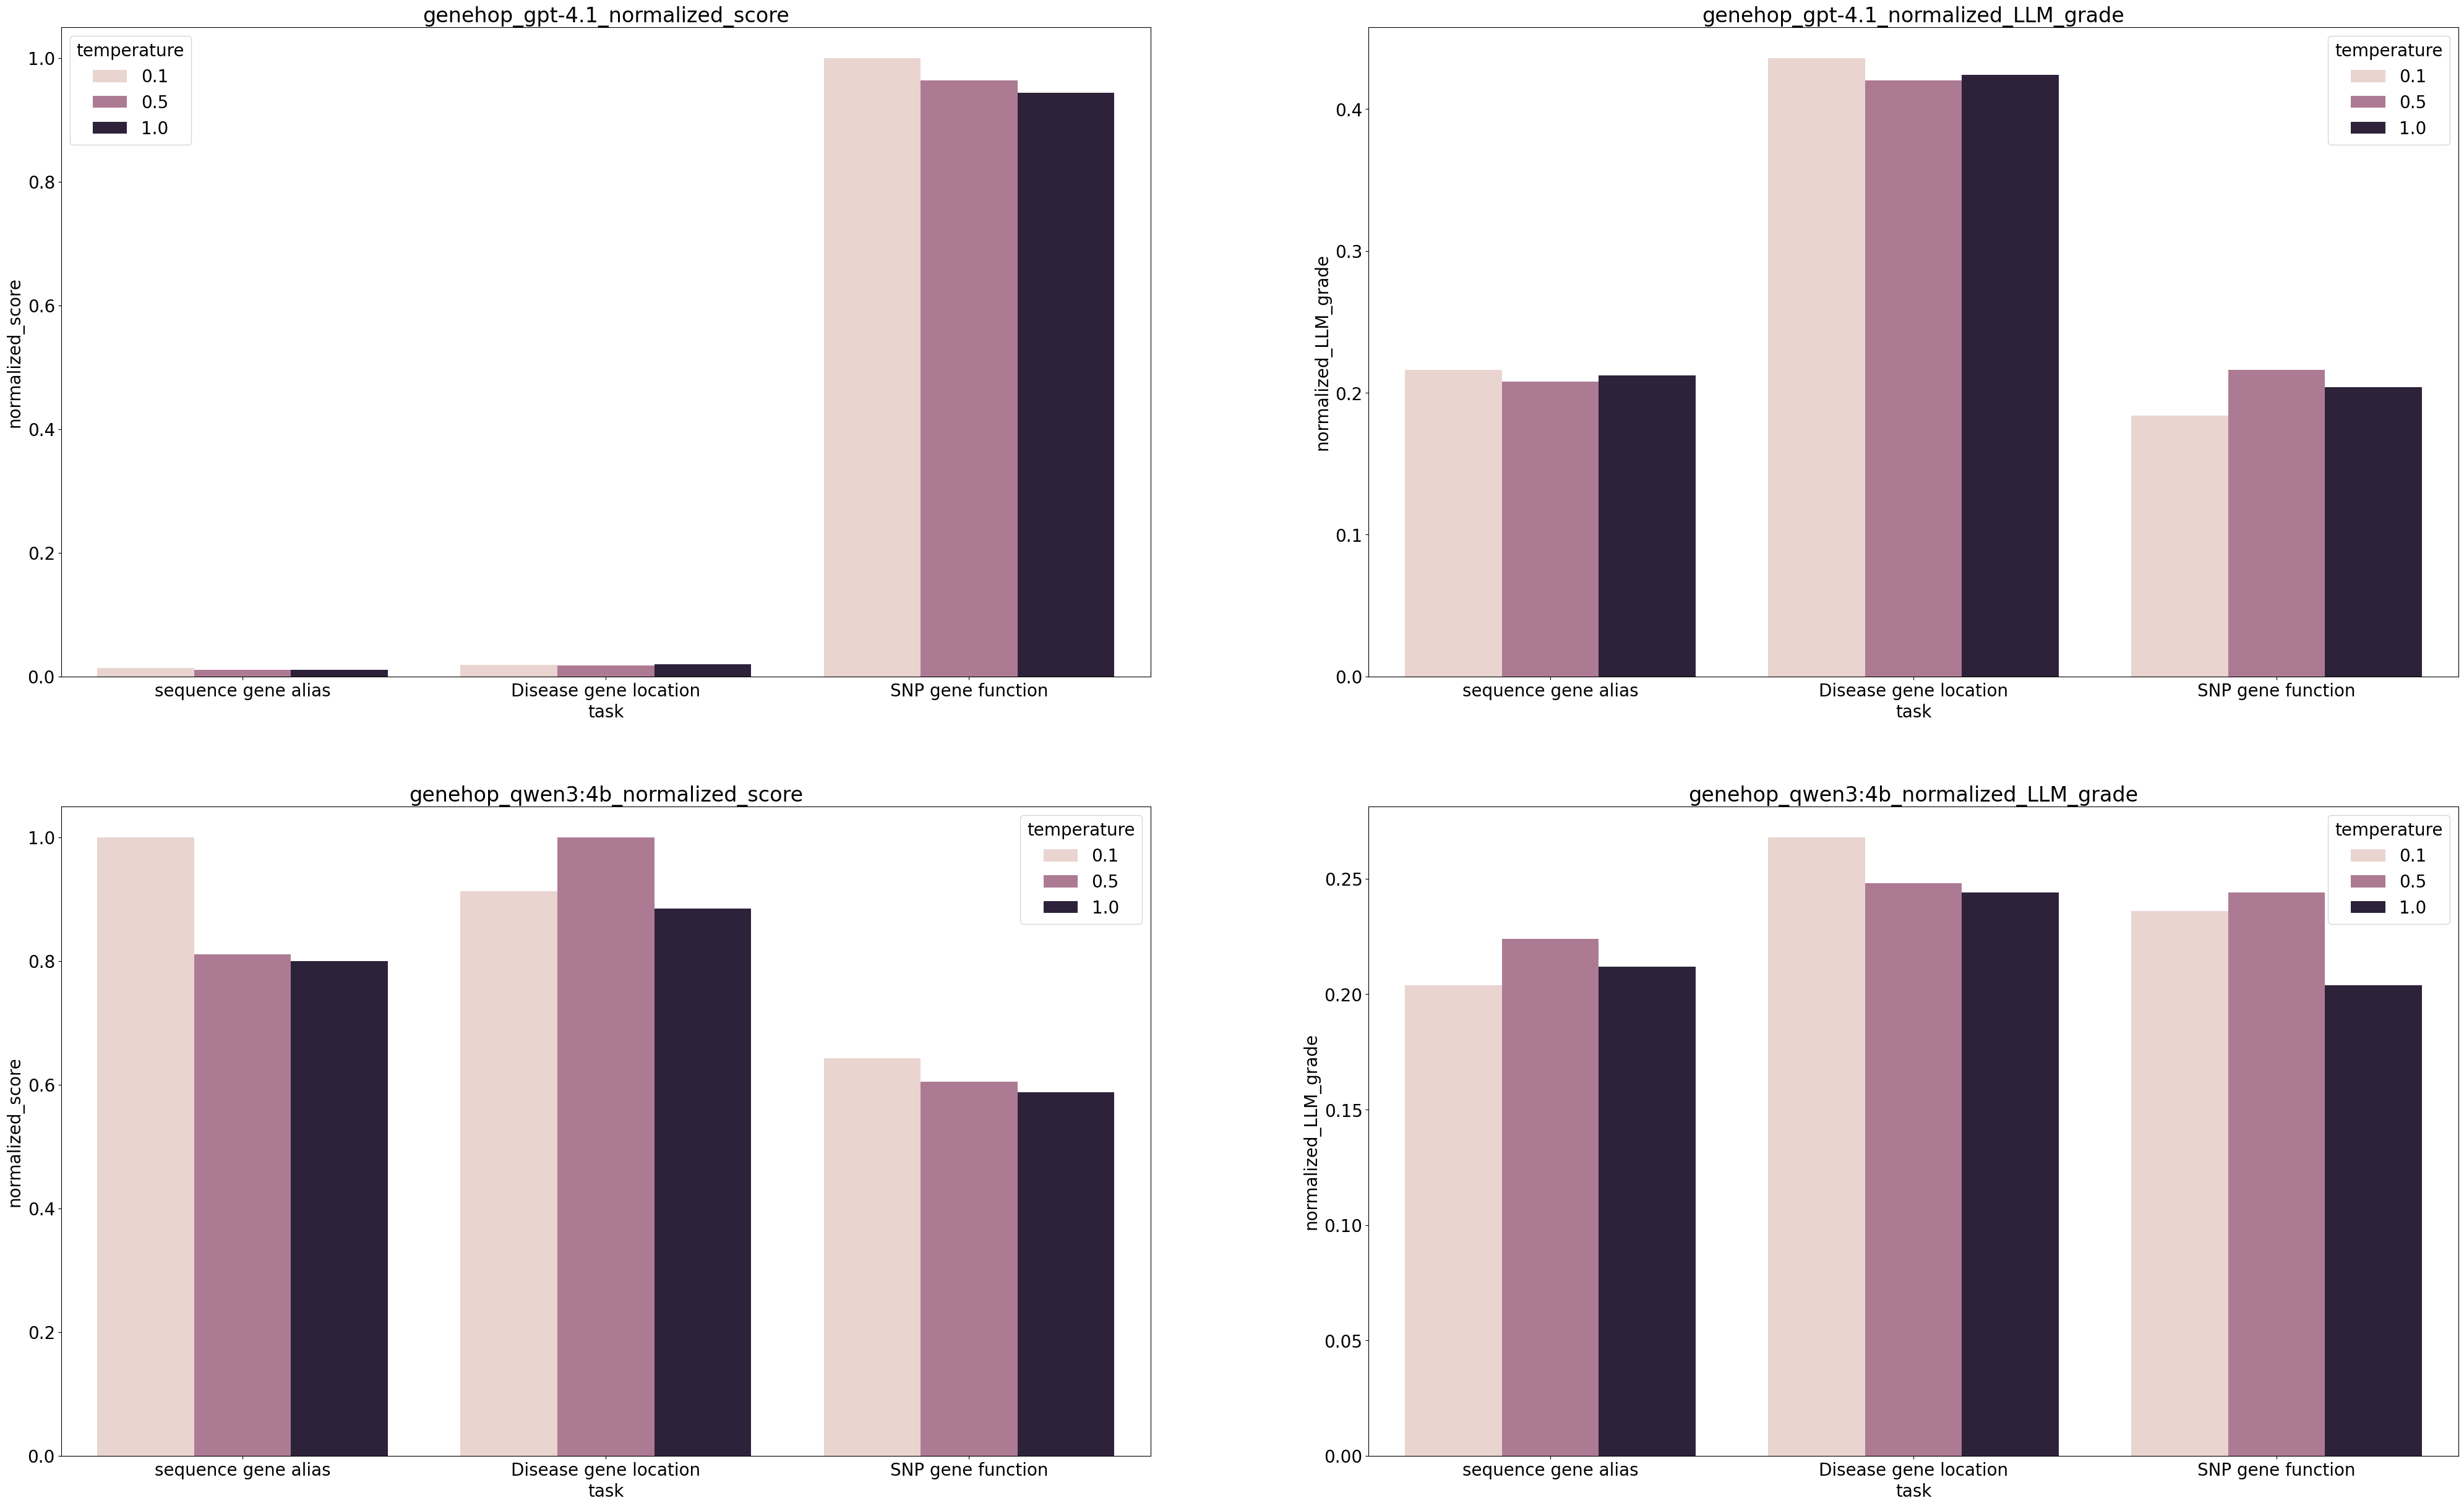

In [153]:
plt.figure(figsize=(50, 30))
nRow = 2
nCol = 2

cnt = 0
for _model_name in raw_metrics.model_name.unique():
    plt.subplot(221+cnt)
    img = raw_metrics[raw_metrics.model_name==_model_name]
    val = 'normalized_score'
    sns.barplot(data=img, x='task', y=val, hue='temperature')
    plt.title(f'genehop_{_model_name}_{val}')
    plt.subplot(222+cnt)
    img = raw_metrics[raw_metrics.model_name==_model_name]
    val = 'normalized_LLM_grade'
    sns.barplot(data=img, x='task', y=val, hue='temperature')
    plt.title(f'genehop_{_model_name}_{val}')
    cnt += 2